<a href="https://colab.research.google.com/github/adigenova/uohpmd/blob/main/code/Pthreads_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variables de condición



In [ ]:
%%writefile cond2.c

#include <pthread.h>
#include <stdio.h>
#include <unistd.h>
#include <assert.h>


const size_t NUMTHREADS = 20;
int done = 0;

pthread_mutex_t mutex = PTHREAD_MUTEX_INITIALIZER;
pthread_cond_t cond = PTHREAD_COND_INITIALIZER;


void* Hilofunc1( void* id )
{
  const int myid = (long)id;

  const int workloops = 5;
  for( int i=0; i<workloops; i++ )
    {
      printf( "[thread %d] working (%d/%d)\n", myid, i, workloops );
      // simulate doing some costly work
      sleep(0.5);
    }

  pthread_mutex_lock( &mutex );
  done++;
  printf( "[thread %d] done is now %d. Signalling cond.\n", myid, done );
  pthread_cond_signal( &cond );
  pthread_mutex_unlock( & mutex );

  return NULL;
}

int main( int argc, char** argv )
{
  puts( "[thread main] starting" );

  pthread_t threads[NUMTHREADS];

  for( int t=0; t<NUMTHREADS; t++ )
    pthread_create( &threads[t], NULL, Hilofunc1, (void*)(long)t );

  // we're going to test "done" so we need the mutex for safety
  pthread_mutex_lock( &mutex );

  // are the other threads still busy?
  while( done < NUMTHREADS)
    {
      printf( "[thread main] done is %d which is < %d so waiting on cond\n",
	      done, (int)NUMTHREADS );

      /* block this thread until another thread signals cond. While
	 blocked, the mutex is released, then re-aquired before this
	 thread is woken up and the call returns. */
      pthread_cond_wait( & cond, & mutex );

      puts( "[thread main] wake - cond was signalled." );

    }

  printf( "[thread main] done == %d so everyone is done\n", (int)NUMTHREADS );

  pthread_mutex_unlock( & mutex );

  return 0;
}

Overwriting cond2.c


In [ ]:
!gcc cond2.c -o cond2 -lpthread

In [ ]:
!./cond2

[thread main] starting
[thread 0] working (0/5)
[thread 1] working (0/5)
[thread 2] working (0/5)
[thread 0] working (1/5)
[thread 1] working (1/5)
[thread 2] working (1/5)
[thread 3] working (0/5)
[thread 4] working (0/5)
[thread 5] working (0/5)
[thread 0] working (2/5)
[thread 1] working (2/5)
[thread 2] working (2/5)
[thread 3] working (1/5)
[thread 4] working (1/5)
[thread 8] working (0/5)
[thread 0] working (3/5)
[thread 1] working (3/5)
[thread 2] working (3/5)
[thread 3] working (2/5)
[thread 4] working (2/5)
[thread 5] working (1/5)
[thread 0] working (4/5)
[thread 3] working (3/5)
[thread 1] working (4/5)
[thread 4] working (3/5)
[thread 2] working (4/5)
[thread 5] working (2/5)
[thread 0] done is now 1. Signalling cond.
[thread 3] working (4/5)
[thread 4] working (4/5)
[thread 5] working (3/5)
[thread 1] done is now 2. Signalling cond.
[thread 2] done is now 3. Signalling cond.
[thread main] done is 3 which is < 20 so waiting on cond
[thread 14] working (0/5)
[thread 5] work

# Productor/Consumidor


Este ejemplo simula un escenario de productor-consumidor con tres hilos productores y dos hilos consumidores. Los productores agregan elementos al búfer, y los consumidores los retiran. El uso de variables de condición permite que los hilos esperen cuando el búfer está lleno o vacío y se señalicen mutuamente cuando pueden continuar su trabajo.

In [10]:
%%writefile productor_consumidor.c

#include <stdio.h>
#include <pthread.h>
#include <stdlib.h>
#include <unistd.h>

#define BUFFER_SIZE 5

int buffer[BUFFER_SIZE];
int count = 0; // Número de elementos en el búfer
pthread_mutex_t mutex;
pthread_cond_t producer_cond;
pthread_cond_t consumer_cond;

void *producer(void *arg) {
    int item;
    for (int i = 0; i < 10; i++) {
        item = rand() % 100; // Genera un número aleatorio

        pthread_mutex_lock(&mutex);

        // Espera si el búfer está lleno
        while (count == BUFFER_SIZE) {
            pthread_cond_wait(&producer_cond, &mutex);
        }

        // Agrega el elemento al búfer
        buffer[count++] = item;
        printf("Productor: agregó %d al búfer. Total de elementos: %d iteracion:%d\n", item, count, i);

        // Señaliza a los consumidores que hay datos disponibles
        pthread_cond_signal(&consumer_cond);

        pthread_mutex_unlock(&mutex);

        // Simula un proceso de producción
        sleep(1);
    }
    pthread_exit(NULL);
}

void *consumer(void *arg) {
    int item;
    for (int i = 0; i < 10; i++) {
        pthread_mutex_lock(&mutex);

        // Espera si el búfer está vacío
        while (count == 0) {
            pthread_cond_wait(&consumer_cond, &mutex);
        }

        // Retira un elemento del búfer
        item = buffer[--count];
        printf("Consumidor: retiró %d del búfer. Total de elementos: %d iteracion:%d\n", item, count, i);

        // Señaliza a los productores que hay espacio disponible
        pthread_cond_signal(&producer_cond);

        pthread_mutex_unlock(&mutex);

        // Simula un proceso de consumo
        sleep(1);
    }
    pthread_exit(NULL);
}

int main() {
    pthread_t producer_threads[3];
    pthread_t consumer_threads[2];

    // Inicializar el mutex y las variables de condición
    pthread_mutex_init(&mutex, NULL);
    pthread_cond_init(&producer_cond, NULL);
    pthread_cond_init(&consumer_cond, NULL);

    // Crear hilos productores y consumidores
    for (int i = 0; i < 3; i++) {
        pthread_create(&producer_threads[i], NULL, producer, NULL);
    }

    for (int i = 0; i < 2; i++) {
        pthread_create(&consumer_threads[i], NULL, consumer, NULL);
    }

    // Esperar a que los hilos terminen
    for (int i = 0; i < 3; i++) {
        pthread_join(producer_threads[i], NULL);
    }

    for (int i = 0; i < 2; i++) {
        pthread_join(consumer_threads[i], NULL);
    }

    // Destruir el mutex y las variables de condición
    pthread_mutex_destroy(&mutex);
    pthread_cond_destroy(&producer_cond);
    pthread_cond_destroy(&consumer_cond);

    return 0;
}


Overwriting productor_consumidor.c


In [11]:
!gcc productor_consumidor.c -o productor_consumidor -lpthread

In [12]:
!./productor_consumidor

Productor: agregó 83 al búfer. Total de elementos: 1 iteracion:0
Productor: agregó 86 al búfer. Total de elementos: 2 iteracion:0
Productor: agregó 77 al búfer. Total de elementos: 3 iteracion:0
Consumidor: retiró 77 del búfer. Total de elementos: 2 iteracion:0
Consumidor: retiró 86 del búfer. Total de elementos: 1 iteracion:0
Productor: agregó 15 al búfer. Total de elementos: 2 iteracion:1
Productor: agregó 93 al búfer. Total de elementos: 3 iteracion:1
Productor: agregó 35 al búfer. Total de elementos: 4 iteracion:1
Productor: agregó 86 al búfer. Total de elementos: 5 iteracion:2
Consumidor: retiró 86 del búfer. Total de elementos: 4 iteracion:1
Consumidor: retiró 35 del búfer. Total de elementos: 3 iteracion:1
Productor: agregó 92 al búfer. Total de elementos: 4 iteracion:2
Productor: agregó 49 al búfer. Total de elementos: 5 iteracion:2
Consumidor: retiró 49 del búfer. Total de elementos: 4 iteracion:2
Productor: agregó 21 al búfer. Total de elementos: 5 iteracion:3
Consumidor: ret

version mejorada sin deadlocks!

In [20]:
%%writefile productor_consumidor2.c


#include <stdio.h>
#include <pthread.h>
#include <stdlib.h>
#include <unistd.h>

#define BUFFER_SIZE 5

int buffer[BUFFER_SIZE];
int count = 0; // Número de elementos en el búfer
int producers_finished = 0;
pthread_mutex_t mutex;
pthread_cond_t producer_cond;
pthread_cond_t consumer_cond;

void *producer(void *arg) {
    int item;
    for (int i = 0; i < 10; i++) {
        item = rand() % 100; // Genera un número aleatorio

        pthread_mutex_lock(&mutex);

        // Espera si el búfer está lleno
        while (count == BUFFER_SIZE) {
            pthread_cond_wait(&producer_cond, &mutex);
        }

        // Agrega el elemento al búfer
        buffer[count++] = item;
        printf("Productor: agregó %d al búfer. Total de elementos: %d iter=%d\n", item, count, i);

        // Señaliza a los consumidores que hay datos disponibles
        pthread_cond_signal(&consumer_cond);

        pthread_mutex_unlock(&mutex);

        // Simula un proceso de producción
        sleep(1);
    }
    pthread_exit(NULL);
}

void *consumer(void *arg) {
    int item;
    int iter=0;

    while (1) {
        pthread_mutex_lock(&mutex);

        // Espera si el búfer está vacío
        while (count == 0 && !producers_finished) {
            pthread_cond_wait(&consumer_cond, &mutex);
        }

        // Si el búfer está vacío y los productores han terminado, el hilo consumidor sale del bucle
        if (count == 0 && producers_finished) {
            pthread_mutex_unlock(&mutex);
            break;
        }

        // Retira un elemento del búfer
        item = buffer[--count];
        printf("Consumidor: retiró %d del búfer. Total de elementos: %d iteration=%d\n", item, count, iter);

        // Señaliza a los productores que hay espacio disponible
        pthread_cond_signal(&producer_cond);

        pthread_mutex_unlock(&mutex);

        // Simula un proceso de consumo
        sleep(1);
    }
    pthread_exit(NULL);
}

int main() {
    pthread_t producer_threads[3];
    pthread_t consumer_threads[2];

    // Inicializar el mutex y las variables de condición
    pthread_mutex_init(&mutex, NULL);
    pthread_cond_init(&producer_cond, NULL);
    pthread_cond_init(&consumer_cond, NULL);

    // Crear hilos productores y consumidores
    for (int i = 0; i < 3; i++) {
        pthread_create(&producer_threads[i], NULL, producer, NULL);
    }

    for (int i = 0; i < 2; i++) {
        pthread_create(&consumer_threads[i], NULL, consumer, NULL);
    }

    // Esperar a que los hilos productores terminen
    for (int i = 0; i < 3; i++) {
        pthread_join(producer_threads[i], NULL);
    }

    // Señalar que los productores han terminado
    pthread_mutex_lock(&mutex);
    //el productor finalizo la operacion, debemos indicar que terminamos la produccion
    printf("Productor: Todos los productores finalizaron\n");
    producers_finished = 1;
    //que hace pthread_cond_broadcast?
    pthread_cond_broadcast(&consumer_cond);
    pthread_mutex_unlock(&mutex);

    // Esperar a que los hilos consumidores terminen
    for (int i = 0; i < 2; i++) {
        pthread_join(consumer_threads[i], NULL);
    }

    // Destruir el mutex y las variables de condición
    pthread_mutex_destroy(&mutex);
    pthread_cond_destroy(&producer_cond);
    pthread_cond_destroy(&consumer_cond);

    return 0;
}


Overwriting productor_consumidor2.c


In [21]:
!gcc productor_consumidor2.c -o productor_consumidor2 -lpthread

In [22]:
!./productor_consumidor2

Productor: agregó 83 al búfer. Total de elementos: 1 iter=0
Productor: agregó 86 al búfer. Total de elementos: 2 iter=0
Productor: agregó 77 al búfer. Total de elementos: 3 iter=0
Consumidor: retiró 77 del búfer. Total de elementos: 2 iteration=0
Consumidor: retiró 86 del búfer. Total de elementos: 1 iteration=0
Productor: agregó 15 al búfer. Total de elementos: 2 iter=1
Productor: agregó 93 al búfer. Total de elementos: 3 iter=1
Productor: agregó 35 al búfer. Total de elementos: 4 iter=1
Consumidor: retiró 35 del búfer. Total de elementos: 3 iteration=0
Consumidor: retiró 93 del búfer. Total de elementos: 2 iteration=0
Productor: agregó 86 al búfer. Total de elementos: 3 iter=2
Productor: agregó 92 al búfer. Total de elementos: 4 iter=2
Productor: agregó 49 al búfer. Total de elementos: 5 iter=2
Consumidor: retiró 49 del búfer. Total de elementos: 4 iteration=0
Consumidor: retiró 92 del búfer. Total de elementos: 3 iteration=0
Productor: agregó 21 al búfer. Total de elementos: 4 iter=

## Matrix Multiplication

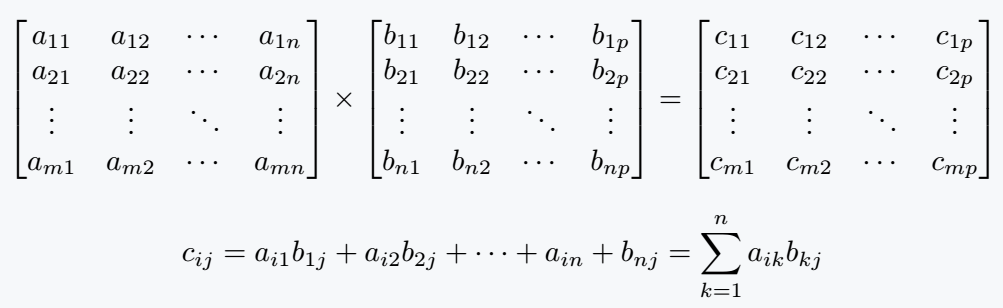

## Ejemplo 3x3


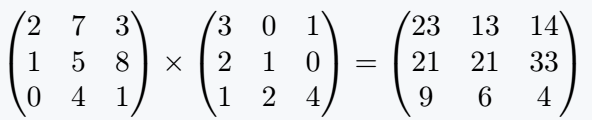

## version serial

In [ ]:
%%writefile matrix1.c

/*
 * Un programa simple para multiplicar matrices
 * (Matrix_A  X  Matrix_B) => Matrix_C
 */

#include <stdio.h>
#include <stdlib.h>

#define ARRAY_SIZE 10

typedef int matrix_t[ARRAY_SIZE][ARRAY_SIZE];

matrix_t MA,MB,MC;

/*
Rutina para multiplicar una fila por una columna y colocar un elemento en
matriz resultante.
*/
void mult(int size,
	  int row,
	  int column,
	  matrix_t MA,
	  matrix_t MB,
	  matrix_t MC)
{
  int position;

  MC[row][column] = 0;
  for(position = 0; position < size; position++) {
    MC[row][column] = MC[row][column] +
      ( MA[row][position]  *  MB[position][column] ) ;
  }
}

//colocamos valores random 1-10 en las matrices
void inicializamos_matriz(int size,
                    matrix_t MX)
{
    int   row, column;
    for(row = 0; row < size; row++) {
    for (column = 0; column < size; column++) {
      MX[row][column]=rand()%10;
    }
  }
}

void imprimir_matriz(int size,
                    matrix_t MX)
{
    int   row, column;
    for(row = 0; row < size; row ++) {
    for (column = 0; column < size; column++) {
      printf("%5d ",MX[row][column]);
    }
    printf("\n");
  }
}


// inicializamos valores y calcula los resultados

int main(void)
{
  int      size, row, column;

  size = ARRAY_SIZE;

  // inicializamos los valores de la MA
  inicializamos_matriz(size, MA);
  //inicializamos los valores de la MB
  inicializamos_matriz(size, MB);
  //imprimimos
  printf("La matriz A es;\n");
  imprimir_matriz(size,MA);
  printf("La matriz B es;\n");
  imprimir_matriz(size,MB);

  // procedemos a realizar la mutiplicacion por filas y columnas
  for(row = 0; row < size; row++) {
    for (column = 0; column < size; column++) {
      mult(size, row, column, MA, MB, MC);
    }
  }

  //imprimimos los resultados
  printf("La matriz resultante C es;\n");
  imprimir_matriz(size,MC);

  return 0;
}

Writing matrix1.c


In [ ]:
!gcc matrix1.c -o matrix1

In [ ]:
!./matrix1

La matriz A es;
    3     6     7     5     3     5     6     2     9     1 
    2     7     0     9     3     6     0     6     2     6 
    1     8     7     9     2     0     2     3     7     5 
    9     2     2     8     9     7     3     6     1     2 
    9     3     1     9     4     7     8     4     5     0 
    3     6     1     0     6     3     2     0     6     1 
    5     5     4     7     6     5     6     9     3     7 
    4     5     2     5     4     7     4     4     3     0 
    7     8     6     8     8     4     3     1     4     9 
    2     0     6     8     9     2     6     6     4     9 
La matriz B es;
    5     0     4     8     7     1     7     2     7     2 
    2     6     1     0     6     1     5     9     4     9 
    0     9     1     7     7     1     1     5     9     7 
    7     6     7     3     6     5     6     3     9     4 
    8     1     2     9     3     9     0     8     8     5 
    0     9     6     3     8     5     6     1     1

## version paralela 1

In [ ]:
%%writefile matrix2.c

/*
 * Un programa simple para multiplicar matrices
 * (Matrix_A  X  Matrix_B) => Matrix_C
 */

#include <stdio.h>
#include <stdlib.h>

#include <pthread.h>


#define ARRAY_SIZE 10

typedef int matrix_t[ARRAY_SIZE][ARRAY_SIZE];


matrix_t MA,MB,MC;


//estructura para enviar trabajos a los hilos
typedef struct {
  int       id;
  int       size;
  int       Arow;
  int       Bcol;
} package_t;


/*
Rutina para multiplicar una fila por una columna y colocar un elemento en
matriz resultante.
*/
void mult(int size,
	  int row,
	  int column,
	  matrix_t MA,
	  matrix_t MB,
	  matrix_t MC)
{
  int position;

  MC[row][column] = 0;
  for(position = 0; position < size; position++) {
    MC[row][column] = MC[row][column] +
      ( MA[row][position]  *  MB[position][column] ) ;
  }
}

//colocamos valores random 1-10 en las matrices
void inicializamos_matriz(int size,
                    matrix_t MX)
{
    int   row, column;
    for(row = 0; row < size; row++) {
    for (column = 0; column < size; column++) {
      //MX[row][column]=rand()%10;
      MX[row][column]=1;
    }
  }
}

void imprimir_matriz(int size,
                    matrix_t MX)
{
    int   row, column;
    for(row = 0; row < size; row ++) {
    for (column = 0; column < size; column++) {
      printf("%5d ",MX[row][column]);
    }
    printf("\n");
  }
}


/*
 * codigo que ejecuta el hilo
 */
void *mult_hilo(void *arg)
{
  package_t *p=(package_t *)arg;

  printf("Hilo %d: procesando A fila %d, B columna %d\n",
	p->id, p->Arow, p->Bcol);

  mult(p->size, p->Arow, p->Bcol, MA, MB, MC);
  printf("Hilo %d: termino\n", p->id);
  free(p);
  return(NULL);
}


// inicializamos valores y calcula los resultados

int main(void)
{
  int      size, row, column, num_threads, i;

  size = ARRAY_SIZE;

  pthread_t *threads;   //puntero a los hilos
  package_t *p;       //argumentos para los hilos



  // inicializamos los valores de la MA
  inicializamos_matriz(size, MA);
  //inicializamos los valores de la MB
  inicializamos_matriz(size, MB);
  //imprimimos
  printf("La matriz A es;\n");
  imprimir_matriz(size,MA);
  printf("La matriz B es;\n");
  imprimir_matriz(size,MB);

 //

  //creamos un hilo para cada elemento de la matriz
  threads = (pthread_t *)malloc(size*size*sizeof(pthread_t));


  //procesamos la matriz por fila, columna
   num_threads = 0;
  for(row = 0; row < size; row++) {
    for (column = 0; column < size; column++) {
      p = (package_t *)malloc(sizeof(package_t));
      p->id = num_threads;
      p->size = size;
      p->Arow = row;
      p->Bcol = column;


      pthread_create(&threads[num_threads],
		     NULL,
		     mult_hilo,
		     (void *) p);
      num_threads++;

    }
  }

  //esperamos que todos los hilos terminen
  for (i = 0; i < (size*size); i++) {
    pthread_join(threads[i], NULL);
  }

  //imprimimos los resultados
  printf("La matriz resultante C es;\n");
  imprimir_matriz(size,MC);

  return 0;
}

Overwriting matrix2.c


In [ ]:
!gcc matrix2.c -o matrix2 -lpthread

In [ ]:
!./matrix2

# version paralela 2

In [ ]:
%%writefile matrix3.c

/*
 * Un programa simple para multiplicar matrices
 * (Matrix_A  X  Matrix_B) => Matrix_C
 */

#include <stdio.h>
#include <stdlib.h>
#include <unistd.h>

#include <pthread.h>


#define ARRAY_SIZE 10

typedef int matrix_t[ARRAY_SIZE][ARRAY_SIZE];


matrix_t MA,MB,MC;


//estructura para enviar trabajos a los hilos
typedef struct {
  int       id;
  int       size;
  int       Arow;
  int       Bcol;
} package_t;

package_t *jobs;
int jobcounter=0;
//the maximum amount of jobs to process
int JOB_MAX=ARRAY_SIZE*ARRAY_SIZE;

//inicializamos el mutex
pthread_mutex_t getjob_lock=PTHREAD_MUTEX_INITIALIZER;



/*
Rutina para multiplicar una fila por una columna y colocar un elemento en
matriz resultante.
*/
void mult(int size,
	  int row,
	  int column,
	  matrix_t MA,
	  matrix_t MB,
	  matrix_t MC)
{
  int position;

  MC[row][column] = 0;
  for(position = 0; position < size; position++) {
    MC[row][column] = MC[row][column] +
      ( MA[row][position]  *  MB[position][column] ) ;
  }
}

//colocamos valores random 1-10 en las matrices
void inicializamos_matriz(int size,
                    matrix_t MX)
{
    int   row, column;
    for(row = 0; row < size; row++) {
    for (column = 0; column < size; column++) {
      MX[row][column]=rand()%10;
    }
  }
}

void imprimir_matriz(int size,
                    matrix_t MX)
{
    int   row, column;
    for(row = 0; row < size; row ++) {
    for (column = 0; column < size; column++) {
      printf("%5d ",MX[row][column]);
    }
    printf("\n");
  }
}


/*
 * codigo que ejecuta el hilo
 */
void *mult_hilo(void *arg)
{
  int id =(int)arg;

  int jobid=0;
  do{

  pthread_mutex_lock(&getjob_lock);
  jobid=jobcounter;
  jobcounter++;
  if (jobid < JOB_MAX){
  printf("Hilo %d: jobid: %d procesando A fila %d, B columna %d\n",
	id, jobs[jobid].id,jobs[jobid].Arow, jobs[jobid].Bcol);
  }
  pthread_mutex_unlock(&getjob_lock);

  if(jobid < JOB_MAX){
  mult(jobs[jobid].size, jobs[jobid].Arow, jobs[jobid].Bcol, MA, MB, MC);
  }

  sleep(0.2);


  }while(jobid < JOB_MAX);

  printf("Hilo %d: termino\n", id);
  return(NULL);
}



// inicializamos valores y calcula los resultados

int main(void)
{
  int      size, row, column, num_threads, i;

  size = ARRAY_SIZE;

  pthread_t *threads;   //puntero a los hilos

  // inicializamos los valores de la MA
  inicializamos_matriz(size, MA);
  //inicializamos los valores de la MB
  inicializamos_matriz(size, MB);
  //imprimimos
  printf("La matriz A es;\n");
  imprimir_matriz(size,MA);
  printf("La matriz B es;\n");
  imprimir_matriz(size,MB);

  //creamos un hilo para cada elemento de la matriz
  num_threads = 5;
  threads = (pthread_t *)malloc((num_threads)*sizeof(pthread_t));
  //creamos los jobs a realizar
   jobs = (package_t *)malloc(size*size*sizeof(package_t));
  //procesamos la matriz por fila, columna

   i=0;
  for(row = 0; row < size; row++) {
    for (column = 0; column < size; column++) {
      //p = (package_t *)malloc(sizeof(package_t));
      jobs[i].id = i;
      jobs[i].size = size;
      jobs[i].Arow = row;
      jobs[i].Bcol = column;
      i++;
    }
  }

  //creamos los hilos
  for(i=0; i<num_threads; i++){
      pthread_create(&threads[i],
		     NULL,
		     mult_hilo,
		     (void *) i);
  }

  //esperamos que todos los hilos terminen
  for (i = 0; i < num_threads; i++) {
    pthread_join(threads[i], NULL);
  }

  //imprimimos los resultados
  printf("La matriz resultante C es;\n");
  imprimir_matriz(size,MC);

  return 0;
}

Writing matrix3.c


In [ ]:
!gcc matrix3.c -o matrix3 -lpthread

matrix3.c: In function ‘mult_hilo’:
matrix3.c:90:11: warning: cast from pointer to integer of different size [-Wpointer-to-int-cast]
   int id =(int)arg;
           ^
matrix3.c: In function ‘main’:
matrix3.c:163:8: warning: cast to pointer from integer of different size [-Wint-to-pointer-cast]
        (void *) i);
        ^


In [ ]:
!./matrix3

La matriz A es;
    3     6     7     5     3     5     6     2     9     1 
    2     7     0     9     3     6     0     6     2     6 
    1     8     7     9     2     0     2     3     7     5 
    9     2     2     8     9     7     3     6     1     2 
    9     3     1     9     4     7     8     4     5     0 
    3     6     1     0     6     3     2     0     6     1 
    5     5     4     7     6     5     6     9     3     7 
    4     5     2     5     4     7     4     4     3     0 
    7     8     6     8     8     4     3     1     4     9 
    2     0     6     8     9     2     6     6     4     9 
La matriz B es;
    5     0     4     8     7     1     7     2     7     2 
    2     6     1     0     6     1     5     9     4     9 
    0     9     1     7     7     1     1     5     9     7 
    7     6     7     3     6     5     6     3     9     4 
    8     1     2     9     3     9     0     8     8     5 
    0     9     6     3     8     5     6     1     1

### Ejercicio propuesto
Agregar variable de condicion que permita agregar una hebra que imprima la suma de los valores de la matriz.

# Count k-mers in python

In [ ]:
#!/usr/bin/env python

import sys
#to read compressed files
import gzip

base_for = "ACGT"
base_rev = "TGCA"
comp_tab = str.maketrans(base_for, base_rev)

def count_kmer(h, k, seq):
	l = len(seq)
	if l < k: return
	for i in range(l - k + 1):
		kmer_for = seq[i:(i+k)]
		if 'N' in kmer_for: continue
		kmer_rev = kmer_for.translate(comp_tab)[::-1]
		if kmer_for < kmer_rev: kmer = kmer_for
		else: kmer = kmer_rev
		if kmer in h:
			h[kmer] += 1
		else: h[kmer] = 1

def count_stdin(k):
	counter = {}
	seq = []
	for line in sys.stdin:
		if line[0] == '>':
			if len(seq) > 0:
				count_kmer(counter, k, ''.join(seq).upper())
				seq = []
		else:
			seq.append(line[:-1])
	if len(seq) > 0:
		count_kmer(counter, k, ''.join(seq).upper())
	return counter


def count_file(file, k):
	seqs=open(file,"r")
	seq=[]
	counter = {}
	for line in seqs:
		if line[0] == '>':
			if len(seq) > 0:
				count_kmer(counter,k,''.join(seq).upper())
				seq = []
		else:
			seq.append(line[:-1])
	if len(seq) > 0:
		count_kmer(counter,k,''.join(seq).upper())

	seqs.close()
	return counter



def count_filegz(file, k):
	seqs=gzip.open(file,"rt")
	seq=[]
	counter = {}
	for line in seqs:
		if line[0] == '>':
			if len(seq) > 0:
				count_kmer(counter,k,''.join(seq).upper())
				seq = []
		else:
			seq.append(line[:-1])
	if len(seq) > 0:
		count_kmer(counter,k,''.join(seq).upper())

	seqs.close()
	return counter


def print_hist(counter,max=256):
	hist = [0] * 256
	for kmer in counter:
		cnt = counter[kmer]
		if cnt > 255: cnt = 255
		hist[cnt] += 1
	for i in range(1, max):
		print("{}\t{}".format(i, hist[i]))


In [ ]:

#counter = count_stdin(22)
#counter = count_filegz(sys.argv[1],22)
counter= count_file("example1.fasta",22)
a=0
for i in counter:
    print(i," ",counter[i])
    a=a+1
    if a > 10:
      break

print_hist(counter,10)

CTTGCCAAGACTGCGAAGGTGC   1
TGCACCTTCGCAGTCTTGGCAA   1
CTGCACCTTCGCAGTCTTGGCA   1
ACTGCACCTTCGCAGTCTTGGC   1
AACTGCACCTTCGCAGTCTTGG   1
CAAGACTGCGAAGGTGCAGTTC   1
AAGACTGCGAAGGTGCAGTTCG   1
AGACTGCGAAGGTGCAGTTCGC   1
GACTGCGAAGGTGCAGTTCGCA   1
ACTGCGAAGGTGCAGTTCGCAA   1
CTGCGAAGGTGCAGTTCGCAAA   1
1	3889
2	26
3	0
4	0
5	0
6	0
7	0
8	0
9	0


In [ ]:
%%writefile kc1.py

#!/usr/bin/env python

import sys
#to read compressed files
import gzip

base_for = "ACGT"
base_rev = "TGCA"
comp_tab = str.maketrans(base_for, base_rev)

def count_kmer(h, k, seq):
	l = len(seq)
	if l < k: return
	for i in range(l - k + 1):
		kmer_for = seq[i:(i+k)]
		if 'N' in kmer_for: continue
		kmer_rev = kmer_for.translate(comp_tab)[::-1]
		if kmer_for < kmer_rev: kmer = kmer_for
		else: kmer = kmer_rev
		if kmer in h:
			h[kmer] += 1
		else: h[kmer] = 1

def count_stdin(k):
	counter = {}
	seq = []
	for line in sys.stdin:
		if line[0] == '>':
			if len(seq) > 0:
				count_kmer(counter, k, ''.join(seq).upper())
				seq = []
		else:
			seq.append(line[:-1])
	if len(seq) > 0:
		count_kmer(counter, k, ''.join(seq).upper())
	return counter


def count_file(file, k):
	seqs=open(file,"r")
	seq=[]
	counter = {}
	for line in seqs:
		if line[0] == '>':
			if len(seq) > 0:
				count_kmer(counter,k,''.join(seq).upper())
				seq = []
		else:
			seq.append(line[:-1])
	if len(seq) > 0:
		count_kmer(counter,k,''.join(seq).upper())

	seqs.close()
	return counter



def count_filegz(file, k):
	seqs=gzip.open(file,"rt")
	seq=[]
	counter = {}
	for line in seqs:
		if line[0] == '>':
			if len(seq) > 0:
				count_kmer(counter,k,''.join(seq).upper())
				seq = []
		else:
			seq.append(line[:-1])
	if len(seq) > 0:
		count_kmer(counter,k,''.join(seq).upper())

	seqs.close()
	return counter


def print_hist(counter):
	hist = [0] * 256
	for kmer in counter:
		cnt = counter[kmer]
		if cnt > 255: cnt = 255
		hist[cnt] += 1
	for i in range(1, 256):
		print("{}\t{}".format(i, hist[i]))



counter = count_stdin(22)
#counter = count_filegz(sys.argv[1],22)
#counter= count_file(sys.argv[1],22)
#print(counter)
print_hist(counter)

Writing kc1.py


In [ ]:
%%writefile example1.fasta
>HWI-ST180_0186:3:1:1484:1936#GGCTAC/1
NCTTGCCAAGACTGCGAAGGTGCAGTTCGCAAAGCGCGTACGCTGGCCACGTGTCCAAAACGTACGTTGGAGGGCGCCTTCGTCAACTCCGGAGCGAACG
>HWI-ST180_0186:3:1:1484:1936#GGCTAC/2
GAGATCTCCAGCATCTGGGCGAGCGCGGCCTGACTGAACCCGCGTTCGCTCCGGAGTTGACGAAGGCGCCCTCAAACGTACGTTTTTGACACGTCGCGAG
>HWI-ST180_0186:3:1:1408:1946#GGCTAC/1
CGATCTGATCGGCTACCAGGAAACGCCGAGCCATACCCGCCAAAGCGGGTTGCTGCGCCAGCTCAGGATCGTCCGCACAGGCACGCAGCGCCGTGTCGCG
>HWI-ST180_0186:3:1:1408:1946#GGCTAC/2
GGGTTCACGCTTGCCGAGCTGGACTTGGAGGAGCGGCGTGAGGGTGATGTCTTGGGGCGTGACCAGTCTCGGGGCGCGGGGAACGTCAGGAACCGTTCTC
>HWI-ST180_0186:3:1:1328:1975#GGCTAC/1
GTTGAGCAGCGCCAGCTTGAGCTGGCCGTAACCCGGACCACCCAGCTCCGGTCCCAGATGACATGCCCACAGGCCGCGGCGTTTGACCTCTTCCTTGAGC
>HWI-ST180_0186:3:1:1328:1975#GGCTAC/2
GTCGAACCCCTCGATTACGTGTTCCCCAACCCATACGACAAGTCCGACACGGTGGCCATGGATTACGTGCGGCCGCTCAAGGAAGAGGTCAAACGCAGCG
>HWI-ST180_0186:3:1:1272:1980#GGCTAC/1
GGCGAGAGGAACCCGGTGACCTGCGGTTCCGGGAGCATGTGGAACGGTAATACACGATCCACATGAGGAGGTTGTGCGGTGCGCTGGCTCGATGCCGGAG
>HWI-ST180_0186:3:1:1272:1980#GGCTAC/2
AGGGCGGTGCGTTGCCGGACAGAACGGGCAGTGCCCGTAGAAAAGAACGCCCTCCGTCGGCATCGAGCCAGCGACCCGCACAACATCCTAATGCGGTGCG
>HWI-ST180_0186:3:1:1633:1932#GGCTAC/1
NTTAGATCTGCATGCTTGCGAGCATCACGGTCAGGTATTTCGCGGCCGCCGCGGCGGCTGCCGGGCTTCAGGCAGAAACCGTCGATCTGCCCGCCGGGGC
>HWI-ST180_0186:3:1:1633:1932#GGCTAC/2
GGTCTCGGACGGCCACGCCGTCATGGAGAAAGGAACAACGCGCCAATACGCGTTCGAGTTCCGGCCCCCTGGAGGCCACCAGACGGGACAGCACGTAGAC
>HWI-ST180_0186:3:1:1896:1989#GGCTAC/1
ATCCTGGAAACCATGACGCGATGGCGCCCCTACCTGGCAGGGGAGCGCACCTCGTTTTCCTACTACCCCAACAGTGCCGCGGTAGGTCTCGGTGCGATGG
>HWI-ST180_0186:3:1:1896:1989#GGCTAC/2
ACAGCACGTGCCCGCCGTGCGCGCCACCTTGCTTGAAGATGACACCCTGCGCTGCCGGTTTCGTGGTGACTTCGGCGAGGATCGAAAAGGATTGGCCGCG
>HWI-ST180_0186:3:1:2009:1964#GGCTAC/1
CCGACCGCGAAGCCACGCTCGGCCAGCTCGTCGGAAACCTTCTGGGCGGTGCGCTTGGTGCGGGTGAAGATCATGGTGGCGCCCCGCCCGTCGGCCTGCA
>HWI-ST180_0186:3:1:2009:1964#GGCTAC/2
AGGTGATCGAGGAATGCCGCGCCGAAGGCTACCTGGGGGAACTGCTCACCCCCGCCGGCCGGCAACTGTACTCCATGATGGCCGGCGTGGCGGGCGACAT
>HWI-ST180_0186:3:1:3317:1945#GGCTAC/1
GAAGATATGCACGATCACCACGCTGCGCGACCGCCGGAATCCCAAACCGGCGTCCTCGGCGATGATGTCGCCCGCGTCGTGTGCGGTGATGATCTGAAAA
>HWI-ST180_0186:3:1:3317:1945#GGCTAC/2
CGACCTCACCGCGGATCGGTCCCCGGCAGAACAACGCGCGATCGCCGACGGCGTGCACGAGGGCCTCGTCGCAGTCTTGAAGATCCCTGCCCGAGATAGT
>HWI-ST180_0186:3:1:3891:1947#GGCTAC/1
ACCACCGAGGCTGTGACCGAAAAGTACGTCTTGCTTGTCGCTGGCGGGCAGGGCCGATGCAATGCCTTCTGCGAGCAGGGGCACTGACGCTATCGGCTGG
>HWI-ST180_0186:3:1:3891:1947#GGCTAC/2
GACGGGAACGGTGCGACGCGGGTGATCTGTTTCCCTCACGCAGGCGGTTCCGCCAGTTACTTCAGGCGATTGGCGAAGATGCTGCCGGCCGACACCGCAG
>HWI-ST180_0186:3:1:4098:1926#GGCTAC/1
NTCGTGATAGTGCCGCACCGTGCGCAAGCTGGTGCCGGCAAGATCGGCAAGCTCTCGAGTGCTCCAGCCCACCGCCACTCCTTCAGCATCCGTTGCCATG
>HWI-ST180_0186:3:1:4098:1926#GGCTAC/2
AATGCCAATATATGGCAAACCGCACTGTCTGCGGCGCGGGGTAGCCGCTGATGGCGGCGGGGTTTCTGTGTTTACCTTTCCCGCACGGCCTTGGGTGCGG
>HWI-ST180_0186:3:1:4443:1926#GGCTAC/1
NGATGCCTGGGCGTCCAACCGTCGCGGATCTGGAATGCGTAGCGCTGCAGGATGGCTCCCAAGACCAGGGTTCCCTCGATGTAGGCCATTCGGGTCCCCA
>HWI-ST180_0186:3:1:4443:1926#GGCTAC/2
CCCGATCGATTCCTGACCGACAGGATCAATCGGAATACCTTCCTGCCGTTCAGCATCGGGCCACGCAAATGCATGGGGACCCGAATGGCCTACATCGAGG
>HWI-ST180_0186:3:1:4881:1938#GGCTAC/1
NTTGGCTTCCCTGCCGGGAGTGCCCGAAGCCGCCGAAGCCCCCCGCGCCGGGTTGACCAAGGTACATCGTCACCGCGCCAATCTTGGTGGTTGGCCGGGG
>HWI-ST180_0186:3:1:4881:1938#GGCTAC/2
ATCGAGTGCCGACGAAGACCTGGCGGCGCGTACCGCTGCCTCCGCCGCGGTCACCGGCCAGCCACGCAGATTGGGGCGGTGACGATGTACCTTGGTCACG
>HWI-ST180_0186:3:1:5841:1991#GGCTAC/1
ATGCAGGATCGCGGTCACCTTGACCCGCATGAAGATCCGCAACGGCTCGCCGCGGCGGTTCTCGCGACCTTGCAGGGGGGGGTGCTGATGGGCGGGGGAA
>HWI-ST180_0186:3:1:5841:1991#GGCTAC/2
GCTAAATTCTGGGCTAGTCGCGCAGTGCGCGTCGAATGCTGTCGAGGGCCATCTAGAGGCTGTCTCGCAAGACGGGGATGGCCATGGCGGCCCGTCCCCG
>HWI-ST180_0186:3:1:6086:1933#GGCTAC/1
NTGTACGCGGTGAATGCGGCGCCGTGGGACATCGGCGGGCCTCAGCCGGGGGTCCGGCGGGTGGGCGCCCCCCGCGGCGGACGAGGGGAGGGGGTGGGTA
>HWI-ST180_0186:3:1:6086:1933#GGCTAC/2
GGATCTAGCACCTCACCTCGTACCGCGCCGAGGGCGACCAGCTGCCGGATCACCGGCTGAGGCCCGCCGATGTCCCCCGGCGCCGCATTCACCGCGTACA
>HWI-ST180_0186:3:1:6737:1946#GGCTAC/1
GTAGTGCAGGGGCCGGAAAGCATGTGCGGCGATACCGCCGAACAATGCACGGGCTTGTCTTGTTCGAAAGAGTTGTGCCGTGGCAGCGGCGGGTAGGACG
>HWI-ST180_0186:3:1:6737:1946#GGCTAC/2
ATGGCCTGGGACGCGACGGGCGCCGGTGGCGGGCGCTATTCGAACGGCCGGCACGCAACTTTGATCTACTGACGGCGGACATCATGGGACCACTGCCAAT
>HWI-ST180_0186:3:1:6755:1956#GGCTAC/1
ACCCGAAATGTCGACACTCGACGGAAAAGAACCTCGTTAGACGGCGCTCTTGTGCTTGCGCTGCGCGGCGAAGAAGTCAGCCCACGACTCCACCTCGGGG
>HWI-ST180_0186:3:1:6755:1956#GGCTAC/2
GGCCGCGGTCATCTGCCGGCACTGCCCGGTGATGATGGAATGCGGTGCCGATGCGCTGGATAACCGCGTGGAGTTCGGTGTTTGGGGGGGTCTGACCGAC
>HWI-ST180_0186:3:1:7009:1994#GGCTAC/1
GGCGTGCCAGCTGCCTGCCGATGTCCTCCGATGTCAGTTCGACACCAGCGACCATGCCTTCCAAGACCGCGACCAGCGCGCGTCCGTGCGATTCACCTGC
>HWI-ST180_0186:3:1:7009:1994#GGCTAC/2
ACTGCGCCGATCGATTTGGAGGACCGACCTGCCCGCATGGGACAATGGAAGACGTGTTGCGCTGGATCACGGCAGGGGAATCGCACGGACGCGCGCTGGT
>HWI-ST180_0186:3:1:7325:1982#GGCTAC/1
GCCGAGGCACAACTCCCGTCAGGCGCCGCATTGGCCCAGGCTTTCCAAAAGAAGGCTTCTGGCAGCTCGACAAGTGCCGACAACACATTCCAGTCGCACA
>HWI-ST180_0186:3:1:7325:1982#GGCTAC/2
AAGTGAAGCGAGGAATGCTAGGCGAGACACCGTCGTTGCCCTGCTAGCGGCCCTGCTGCCCAAAGCTGTTGGCGTTATTTGCGTCAGTTGCTTTGTAGCC
>HWI-ST180_0186:3:1:7687:1930#GGCTAC/1
NATGGATTCCCCGACAGGCAAATCGAATTCGAGCCGCCAATCCGACATCGGCGCAGTGCTCATGTTGGTAACGGTGAAGCGGGCGATGAAACCGGTCTGC
>HWI-ST180_0186:3:1:7687:1930#GGCTAC/2
CATACCCGCGATACAGAGCTGATATCGCAGGTATGGCGTTAATGTGGGCTGCTATGGCAGGACTCCGCAACAGGCTGGTGGGGTGGGGGGGACTACTTCC
>HWI-ST180_0186:3:1:8093:1987#GGCTAC/1
GGAGCGATCGTGGCCCTGGGGGCACAACGGCTCGCGGGGCTGGGTCTACAAGGCATTGACGACCAACCCTTGGTGGCGGCGGTCGCGGGCGGTGATCTGT
>HWI-ST180_0186:3:1:8093:1987#GGCTAC/2
CGCTTCAAAGGCCACATTCGGGCTGAGCCCGAGCGACCGGCATTCGGACTCCAGGATGGACCGAACGCCACTACCGGTGGGCAGGCAGATCAGGGTGTGC
>HWI-ST180_0186:3:1:8944:1971#GGCTAC/1
CCACCGGCGGGAAGTGCGTGAACACCCCCGTGCCGTCGATCCCCTCCCAGATGAAGGTGTGATGCGGCATCCGATTCACGGAATTCCACGAAATCTTTTG
>HWI-ST180_0186:3:1:8944:1971#GGCTAC/2
GGCTGCCCGATTCCTTTGGCTACTCCGCGGCGATGCCGCAGATCGTCGGCGCGTCCCGGTCCGGATAATTTTTTTCGGCAAAAAATTTTGTGGATTCCGC
>HWI-ST180_0186:3:1:8849:1992#GGCTAC/1
CTTAACGTCGCTTTAGAGATCAGAAGGCGCCGTAAGCAGCGACAGGCCCGATGACGATGATTGCCGGCGGGCTGATGCCCTGCGAGCGGATGGGTTCTGG
>HWI-ST180_0186:3:1:8849:1992#GGCTAC/2
TGCTGATGGCTGTCGAGCGCATCGAGCAGTTCGCGAGGGTGCTCATTGAAGGGGGCCGACCTGCGCATACCCCGGTATTGGTGGGTTCAACCGGCACCAC
>HWI-ST180_0186:3:1:10111:1957#GGCTAC/1
GGAACGTAGAGCTGCTGCGCCAGCAGATCTCCGAAACCGGGGTCACCAATGTCGCGGTGGCAGACGAGCGCGCTGCCGTGCGGCTCGACATCCCCGTGCT
>HWI-ST180_0186:3:1:10111:1957#GGCTAC/2
GGAGTGTTCGGAATCGACAGGCACGATTTGCCCGGGCGCGGCGGCCTTGGTGACAAGCGGCCCACCGGCCACCAGGGATTCCTTATTGGACAAGGACAAC
>HWI-ST180_0186:3:1:10753:1915#GGCTAN/1
NGTGCGACGAAGCAGCTTGCGGTGCTTCTTCTTGGACATACGCTTACGCCGCTTCTTGATGACTGAACCCATGAACTCCTGCTAACTACTGTGAAATCGT
>HWI-ST180_0186:3:1:10753:1915#GGCTAN/2
GGTTTCCTGACGGGGGGCCGTAACGGGTAGAGTCGTGCGGCACCCTGGTTTAAGCCTTGAGGGGTTGGGGCGCTCGTGTACGGCTGGCATCAGCCGTTGT
>HWI-ST180_0186:3:1:11637:1927#GGCTAC/1
NGATTCTTCCCGGGGCTCAATGAGGTCGTCCCGATCATCGTCGACGCGGCCACTCCGGGAAACAAGGCGAAGCACACCGCACGGTGCAGAAACGCGGGAG
>HWI-ST180_0186:3:1:11637:1927#GGCTAC/2
GTATCCGATGCCCAGTTGCTTCACCAGCAGCAGGCCACCGATGAGCGCGGCGACAAAGGCCACGGCCGCGGCACCGAGACACGTGTTGTTGTATCATGAC

Writing example1.fasta


In [ ]:
time ! cat ./example1.fasta |  python3 ./kc1.py | head

python3: can't open file './kc1.py': [Errno 2] No such file or directory
CPU times: user 6.68 ms, sys: 9.2 ms, total: 15.9 ms
Wall time: 122 ms


# Counting k-mers in C

## libraries

### process fasta or fastq files

In [ ]:
%%writefile kseq.h


#ifndef AC_KSEQ_H
#define AC_KSEQ_H

#include <ctype.h>
#include <string.h>
#include <stdlib.h>

#define KS_SEP_SPACE 0 // isspace(): \t, \n, \v, \f, \r
#define KS_SEP_TAB   1 // isspace() && !' '
#define KS_SEP_LINE  2 // line separator: "\n" (Unix) or "\r\n" (Windows)
#define KS_SEP_MAX   2

#ifndef klib_unused
#if (defined __clang__ && __clang_major__ >= 3) || (defined __GNUC__ && __GNUC__ >= 3)
#define klib_unused __attribute__ ((__unused__))
#else
#define klib_unused
#endif
#endif /* klib_unused */

#define __KS_TYPE(type_t) \
	typedef struct __kstream_t { \
		int begin, end; \
		int is_eof:2, bufsize:30; \
		type_t f; \
		unsigned char *buf; \
	} kstream_t;

#define ks_eof(ks) ((ks)->is_eof && (ks)->begin >= (ks)->end)
#define ks_rewind(ks) ((ks)->is_eof = (ks)->begin = (ks)->end = 0)

#define __KS_BASIC(SCOPE, type_t, __bufsize) \
	SCOPE kstream_t *ks_init(type_t f) \
	{ \
		kstream_t *ks = (kstream_t*)calloc(1, sizeof(kstream_t)); \
		ks->f = f; ks->bufsize = __bufsize; \
		ks->buf = (unsigned char*)malloc(__bufsize); \
		return ks; \
	} \
	SCOPE void ks_destroy(kstream_t *ks) \
	{ \
		if (!ks) return; \
		free(ks->buf); \
		free(ks); \
	}

#define __KS_INLINED(__read) \
	static inline klib_unused int ks_getc(kstream_t *ks) \
	{ \
		if (ks->is_eof && ks->begin >= ks->end) return -1; \
		if (ks->begin >= ks->end) { \
			ks->begin = 0; \
			ks->end = __read(ks->f, ks->buf, ks->bufsize); \
			if (ks->end < ks->bufsize) ks->is_eof = 1; \
			if (ks->end == 0) return -1; \
		} \
		return (int)ks->buf[ks->begin++]; \
	} \
	static inline int ks_getuntil(kstream_t *ks, int delimiter, kstring_t *str, int *dret) \
	{ return ks_getuntil2(ks, delimiter, str, dret, 0); }

#ifndef KSTRING_T
#define KSTRING_T kstring_t
typedef struct __kstring_t {
	unsigned l, m;
	char *s;
} kstring_t;
#endif

#ifndef kroundup32
#define kroundup32(x) (--(x), (x)|=(x)>>1, (x)|=(x)>>2, (x)|=(x)>>4, (x)|=(x)>>8, (x)|=(x)>>16, ++(x))
#endif

#define __KS_GETUNTIL(SCOPE, __read) \
	SCOPE int ks_getuntil2(kstream_t *ks, int delimiter, kstring_t *str, int *dret, int append) \
	{ \
		if (dret) *dret = 0; \
		str->l = append? str->l : 0; \
		if (ks->begin >= ks->end && ks->is_eof) return -1; \
		for (;;) { \
			int i; \
			if (ks->begin >= ks->end) { \
				if (!ks->is_eof) { \
					ks->begin = 0; \
					ks->end = __read(ks->f, ks->buf, ks->bufsize); \
					if (ks->end < ks->bufsize) ks->is_eof = 1; \
					if (ks->end == 0) break; \
				} else break; \
			} \
			if (delimiter == KS_SEP_LINE) { \
				for (i = ks->begin; i < ks->end; ++i) \
					if (ks->buf[i] == '\n') break; \
			} else if (delimiter > KS_SEP_MAX) { \
				for (i = ks->begin; i < ks->end; ++i) \
					if (ks->buf[i] == delimiter) break; \
			} else if (delimiter == KS_SEP_SPACE) { \
				for (i = ks->begin; i < ks->end; ++i) \
					if (isspace(ks->buf[i])) break; \
			} else if (delimiter == KS_SEP_TAB) { \
				for (i = ks->begin; i < ks->end; ++i) \
					if (isspace(ks->buf[i]) && ks->buf[i] != ' ') break; \
			} else i = 0; /* never come to here! */ \
			if (str->m - str->l < (size_t)(i - ks->begin + 1)) { \
				str->m = str->l + (i - ks->begin) + 1; \
				kroundup32(str->m); \
				str->s = (char*)realloc(str->s, str->m); \
			} \
			memcpy(str->s + str->l, ks->buf + ks->begin, i - ks->begin); \
			str->l = str->l + (i - ks->begin); \
			ks->begin = i + 1; \
			if (i < ks->end) { \
				if (dret) *dret = ks->buf[i]; \
				break; \
			} \
		} \
		if (str->s == 0) { \
			str->m = 1; \
			str->s = (char*)calloc(1, 1); \
		} else if (delimiter == KS_SEP_LINE && str->l > 1 && str->s[str->l-1] == '\r') --str->l; \
		str->s[str->l] = '\0'; \
		return str->l; \
	}

#define KSTREAM_INIT2(SCOPE, type_t, __read, __bufsize) \
	__KS_TYPE(type_t) \
	__KS_BASIC(SCOPE, type_t, __bufsize) \
	__KS_GETUNTIL(SCOPE, __read) \
	__KS_INLINED(__read)

#define KSTREAM_INIT(type_t, __read, __bufsize) KSTREAM_INIT2(static, type_t, __read, __bufsize)

#define KSTREAM_DECLARE(type_t, __read) \
	__KS_TYPE(type_t) \
	extern int ks_getuntil2(kstream_t *ks, int delimiter, kstring_t *str, int *dret, int append); \
	extern kstream_t *ks_init(type_t f); \
	extern void ks_destroy(kstream_t *ks); \
	__KS_INLINED(__read)

/******************
 * FASTA/Q parser *
 ******************/

#define kseq_rewind(ks) ((ks)->last_char = (ks)->f->is_eof = (ks)->f->begin = (ks)->f->end = 0)

#define __KSEQ_BASIC(SCOPE, type_t) \
	SCOPE kseq_t *kseq_init(type_t fd) \
	{ \
		kseq_t *s = (kseq_t*)calloc(1, sizeof(kseq_t)); \
		s->f = ks_init(fd); \
		return s; \
	} \
	SCOPE void kseq_destroy(kseq_t *ks) \
	{ \
		if (!ks) return; \
		free(ks->name.s); free(ks->comment.s); free(ks->seq.s);	free(ks->qual.s); \
		ks_destroy(ks->f); \
		free(ks); \
	}

/* Return value:
   >=0  length of the sequence (normal)
   -1   end-of-file
   -2   truncated quality string
 */
#define __KSEQ_READ(SCOPE) \
	SCOPE int kseq_read(kseq_t *seq) \
	{ \
		int c; \
		kstream_t *ks = seq->f; \
		if (seq->last_char == 0) { /* then jump to the next header line */ \
			while ((c = ks_getc(ks)) != -1 && c != '>' && c != '@'); \
			if (c == -1) return -1; /* end of file */ \
			seq->last_char = c; \
		} /* else: the first header char has been read in the previous call */ \
		seq->comment.l = seq->seq.l = seq->qual.l = 0; /* reset all members */ \
		if (ks_getuntil(ks, 0, &seq->name, &c) < 0) return -1; /* normal exit: EOF */ \
		if (c != '\n') ks_getuntil(ks, KS_SEP_LINE, &seq->comment, 0); /* read FASTA/Q comment */ \
		if (seq->seq.s == 0) { /* we can do this in the loop below, but that is slower */ \
			seq->seq.m = 256; \
			seq->seq.s = (char*)malloc(seq->seq.m); \
		} \
		while ((c = ks_getc(ks)) != -1 && c != '>' && c != '+' && c != '@') { \
			if (c == '\n') continue; /* skip empty lines */ \
			seq->seq.s[seq->seq.l++] = c; /* this is safe: we always have enough space for 1 char */ \
			ks_getuntil2(ks, KS_SEP_LINE, &seq->seq, 0, 1); /* read the rest of the line */ \
		} \
		if (c == '>' || c == '@') seq->last_char = c; /* the first header char has been read */ \
		if (seq->seq.l + 1 >= seq->seq.m) { /* seq->seq.s[seq->seq.l] below may be out of boundary */ \
			seq->seq.m = seq->seq.l + 2; \
			kroundup32(seq->seq.m); /* rounded to the next closest 2^k */ \
			seq->seq.s = (char*)realloc(seq->seq.s, seq->seq.m); \
		} \
		seq->seq.s[seq->seq.l] = 0;	/* null terminated string */ \
		if (c != '+') return seq->seq.l; /* FASTA */ \
		if (seq->qual.m < seq->seq.m) {	/* allocate memory for qual in case insufficient */ \
			seq->qual.m = seq->seq.m; \
			seq->qual.s = (char*)realloc(seq->qual.s, seq->qual.m); \
		} \
		while ((c = ks_getc(ks)) != -1 && c != '\n'); /* skip the rest of '+' line */ \
		if (c == -1) return -2; /* error: no quality string */ \
		while (ks_getuntil2(ks, KS_SEP_LINE, &seq->qual, 0, 1) >= 0 && seq->qual.l < seq->seq.l); \
		seq->last_char = 0;	/* we have not come to the next header line */ \
		if (seq->seq.l != seq->qual.l) return -2; /* error: qual string is of a different length */ \
		return seq->seq.l; \
	}

#define __KSEQ_TYPE(type_t) \
	typedef struct { \
		kstring_t name, comment, seq, qual; \
		int last_char; \
		kstream_t *f; \
	} kseq_t;

#define KSEQ_INIT2(SCOPE, type_t, __read) \
	KSTREAM_INIT2(SCOPE, type_t, __read, 16384) \
	__KSEQ_TYPE(type_t) \
	__KSEQ_BASIC(SCOPE, type_t) \
	__KSEQ_READ(SCOPE)

#define KSEQ_INIT(type_t, __read) KSEQ_INIT2(static, type_t, __read)

#define KSEQ_DECLARE(type_t) \
	__KS_TYPE(type_t) \
	__KSEQ_TYPE(type_t) \
	extern kseq_t *kseq_init(type_t fd); \
	void kseq_destroy(kseq_t *ks); \
	int kseq_read(kseq_t *seq);

#endif


Writing kseq.h


### parse arguments library

In [ ]:
%%writefile ketopt.h

#ifndef KETOPT_H
#define KETOPT_H

#include <string.h> /* for strchr() and strncmp() */

#define ko_no_argument       0
#define ko_required_argument 1
#define ko_optional_argument 2

typedef struct {
	int ind;   /* equivalent to optind */
	int opt;   /* equivalent to optopt */
	char *arg; /* equivalent to optarg */
	int longidx; /* index of a long option; or -1 if short */
	/* private variables not intended for external uses */
	int i, pos, n_args;
} ketopt_t;

typedef struct {
	char *name;
	int has_arg;
	int val;
} ko_longopt_t;

static ketopt_t KETOPT_INIT = { 1, 0, 0, -1, 1, 0, 0 };

static void ketopt_permute(char *argv[], int j, int n) /* move argv[j] over n elements to the left */
{
	int k;
	char *p = argv[j];
	for (k = 0; k < n; ++k)
		argv[j - k] = argv[j - k - 1];
	argv[j - k] = p;
}

/**
 * Parse command-line options and arguments
 *
 * This fuction has a similar interface to GNU's getopt_long(). Each call
 * parses one option and returns the option name.  s->arg points to the option
 * argument if present. The function returns -1 when all command-line arguments
 * are parsed. In this case, s->ind is the index of the first non-option
 * argument.
 *
 * @param s         status; shall be initialized to KETOPT_INIT on the first call
 * @param argc      length of argv[]
 * @param argv      list of command-line arguments; argv[0] is ignored
 * @param permute   non-zero to move options ahead of non-option arguments
 * @param ostr      option string
 * @param longopts  long options
 *
 * @return ASCII for a short option; ko_longopt_t::val for a long option; -1 if
 *         argv[] is fully processed; '?' for an unknown option or an ambiguous
 *         long option; ':' if an option argument is missing
 */
static int ketopt(ketopt_t *s, int argc, char *argv[], int permute, const char *ostr, const ko_longopt_t *longopts)
{
	int opt = -1, i0, j;
	if (permute) {
		while (s->i < argc && (argv[s->i][0] != '-' || argv[s->i][1] == '\0'))
			++s->i, ++s->n_args;
	}
	s->arg = 0, s->longidx = -1, i0 = s->i;
	if (s->i >= argc || argv[s->i][0] != '-' || argv[s->i][1] == '\0') {
		s->ind = s->i - s->n_args;
		return -1;
	}
	if (argv[s->i][0] == '-' && argv[s->i][1] == '-') { /* "--" or a long option */
		if (argv[s->i][2] == '\0') { /* a bare "--" */
			ketopt_permute(argv, s->i, s->n_args);
			++s->i, s->ind = s->i - s->n_args;
			return -1;
		}
		s->opt = 0, opt = '?', s->pos = -1;
		if (longopts) { /* parse long options */
			int k, n_exact = 0, n_partial = 0;
			const ko_longopt_t *o = 0, *o_exact = 0, *o_partial = 0;
			for (j = 2; argv[s->i][j] != '\0' && argv[s->i][j] != '='; ++j) {} /* find the end of the option name */
			for (k = 0; longopts[k].name != 0; ++k)
				if (strncmp(&argv[s->i][2], longopts[k].name, j - 2) == 0) {
					if (longopts[k].name[j - 2] == 0) ++n_exact, o_exact = &longopts[k];
					else ++n_partial, o_partial = &longopts[k];
				}
			if (n_exact > 1 || (n_exact == 0 && n_partial > 1)) return '?';
			o = n_exact == 1? o_exact : n_partial == 1? o_partial : 0;
			if (o) {
				s->opt = opt = o->val, s->longidx = o - longopts;
				if (argv[s->i][j] == '=') s->arg = &argv[s->i][j + 1];
				if (o->has_arg == 1 && argv[s->i][j] == '\0') {
					if (s->i < argc - 1) s->arg = argv[++s->i];
					else opt = ':'; /* missing option argument */
				}
			}
		}
	} else { /* a short option */
		char *p;
		if (s->pos == 0) s->pos = 1;
		opt = s->opt = argv[s->i][s->pos++];
		p = strchr((char*)ostr, opt);
		if (p == 0) {
			opt = '?'; /* unknown option */
		} else if (p[1] == ':') {
			if (argv[s->i][s->pos] == 0) {
				if (s->i < argc - 1) s->arg = argv[++s->i];
				else opt = ':'; /* missing option argument */
			} else s->arg = &argv[s->i][s->pos];
			s->pos = -1;
		}
	}
	if (s->pos < 0 || argv[s->i][s->pos] == 0) {
		++s->i, s->pos = 0;
		if (s->n_args > 0) /* permute */
			for (j = i0; j < s->i; ++j)
				ketopt_permute(argv, j, s->n_args);
	}
	s->ind = s->i - s->n_args;
	return opt;
}

#endif


Writing ketopt.h


### Hash library

In [ ]:
%%writefile khashl.h

#ifndef __AC_KHASHL_H
#define __AC_KHASHL_H

#define AC_VERSION_KHASHL_H "0.1"

#include <stdlib.h>
#include <string.h>
#include <limits.h>

/************************************
 * Compiler specific configurations *
 ************************************/

#if UINT_MAX == 0xffffffffu
typedef unsigned int khint32_t;
#elif ULONG_MAX == 0xffffffffu
typedef unsigned long khint32_t;
#endif

#if ULONG_MAX == ULLONG_MAX
typedef unsigned long khint64_t;
#else
typedef unsigned long long khint64_t;
#endif

#ifndef kh_inline
#ifdef _MSC_VER
#define kh_inline __inline
#else
#define kh_inline inline
#endif
#endif /* kh_inline */

#ifndef klib_unused
#if (defined __clang__ && __clang_major__ >= 3) || (defined __GNUC__ && __GNUC__ >= 3)
#define klib_unused __attribute__ ((__unused__))
#else
#define klib_unused
#endif
#endif /* klib_unused */

#define KH_LOCAL static kh_inline klib_unused

typedef khint32_t khint_t;

/******************
 * malloc aliases *
 ******************/

#ifndef kcalloc
#define kcalloc(N,Z) calloc(N,Z)
#endif
#ifndef kmalloc
#define kmalloc(Z) malloc(Z)
#endif
#ifndef krealloc
#define krealloc(P,Z) realloc(P,Z)
#endif
#ifndef kfree
#define kfree(P) free(P)
#endif

/****************************
 * Simple private functions *
 ****************************/

#define __kh_used(flag, i)       (flag[i>>5] >> (i&0x1fU) & 1U)
#define __kh_set_used(flag, i)   (flag[i>>5] |= 1U<<(i&0x1fU))
#define __kh_set_unused(flag, i) (flag[i>>5] &= ~(1U<<(i&0x1fU)))

#define __kh_fsize(m) ((m) < 32? 1 : (m)>>5)

static kh_inline khint_t __kh_h2b(khint_t hash, khint_t bits) { return hash * 2654435769U >> (32 - bits); }

/*******************
 * Hash table base *
 *******************/

#define __KHASHL_TYPE(HType, khkey_t) \
	typedef struct HType { \
		khint_t bits, count; \
		khint32_t *used; \
		khkey_t *keys; \
	} HType;

#define __KHASHL_PROTOTYPES(HType, prefix, khkey_t) \
	extern HType *prefix##_init(void); \
	extern void prefix##_destroy(HType *h); \
	extern void prefix##_clear(HType *h); \
	extern khint_t prefix##_getp(const HType *h, const khkey_t *key); \
	extern int prefix##_resize(HType *h, khint_t new_n_buckets); \
	extern khint_t prefix##_putp(HType *h, const khkey_t *key, int *absent); \
	extern void prefix##_del(HType *h, khint_t k);

#define __KHASHL_IMPL_BASIC(SCOPE, HType, prefix) \
	SCOPE HType *prefix##_init(void) { \
		return (HType*)kcalloc(1, sizeof(HType)); \
	} \
	SCOPE void prefix##_destroy(HType *h) { \
		if (!h) return; \
		kfree((void *)h->keys); kfree(h->used); \
		kfree(h); \
	} \
	SCOPE void prefix##_clear(HType *h) { \
		if (h && h->used) { \
			uint32_t n_buckets = 1U << h->bits; \
			memset(h->used, 0, __kh_fsize(n_buckets) * sizeof(khint32_t)); \
			h->count = 0; \
		} \
	}

#define __KHASHL_IMPL_GET(SCOPE, HType, prefix, khkey_t, __hash_fn, __hash_eq) \
	SCOPE khint_t prefix##_getp(const HType *h, const khkey_t *key) { \
		khint_t i, last, n_buckets, mask; \
		if (h->keys == 0) return 0; \
		n_buckets = 1U << h->bits; \
		mask = n_buckets - 1U; \
		i = last = __kh_h2b(__hash_fn(*key), h->bits); \
		while (__kh_used(h->used, i) && !__hash_eq(h->keys[i], *key)) { \
			i = (i + 1U) & mask; \
			if (i == last) return n_buckets; \
		} \
		return !__kh_used(h->used, i)? n_buckets : i; \
	} \
	SCOPE khint_t prefix##_get(const HType *h, khkey_t key) { return prefix##_getp(h, &key); }

#define __KHASHL_IMPL_RESIZE(SCOPE, HType, prefix, khkey_t, __hash_fn, __hash_eq) \
	SCOPE int prefix##_resize(HType *h, khint_t new_n_buckets) { \
		khint32_t *new_used = 0; \
		khint_t j = 0, x = new_n_buckets, n_buckets, new_bits, new_mask; \
		while ((x >>= 1) != 0) ++j; \
		if (new_n_buckets & (new_n_buckets - 1)) ++j; \
		new_bits = j > 2? j : 2; \
		new_n_buckets = 1U << new_bits; \
		if (h->count > (new_n_buckets>>1) + (new_n_buckets>>2)) return 0; /* requested size is too small */ \
		new_used = (khint32_t*)kmalloc(__kh_fsize(new_n_buckets) * sizeof(khint32_t)); \
		memset(new_used, 0, __kh_fsize(new_n_buckets) * sizeof(khint32_t)); \
		if (!new_used) return -1; /* not enough memory */ \
		n_buckets = h->keys? 1U<<h->bits : 0U; \
		if (n_buckets < new_n_buckets) { /* expand */ \
			khkey_t *new_keys = (khkey_t*)krealloc((void*)h->keys, new_n_buckets * sizeof(khkey_t)); \
			if (!new_keys) { kfree(new_used); return -1; } \
			h->keys = new_keys; \
		} /* otherwise shrink */ \
		new_mask = new_n_buckets - 1; \
		for (j = 0; j != n_buckets; ++j) { \
			khkey_t key; \
			if (!__kh_used(h->used, j)) continue; \
			key = h->keys[j]; \
			__kh_set_unused(h->used, j); \
			while (1) { /* kick-out process; sort of like in Cuckoo hashing */ \
				khint_t i; \
				i = __kh_h2b(__hash_fn(key), new_bits); \
				while (__kh_used(new_used, i)) i = (i + 1) & new_mask; \
				__kh_set_used(new_used, i); \
				if (i < n_buckets && __kh_used(h->used, i)) { /* kick out the existing element */ \
					{ khkey_t tmp = h->keys[i]; h->keys[i] = key; key = tmp; } \
					__kh_set_unused(h->used, i); /* mark it as deleted in the old hash table */ \
				} else { /* write the element and jump out of the loop */ \
					h->keys[i] = key; \
					break; \
				} \
			} \
		} \
		if (n_buckets > new_n_buckets) /* shrink the hash table */ \
			h->keys = (khkey_t*)krealloc((void *)h->keys, new_n_buckets * sizeof(khkey_t)); \
		kfree(h->used); /* free the working space */ \
		h->used = new_used, h->bits = new_bits; \
		return 0; \
	}

#define __KHASHL_IMPL_PUT(SCOPE, HType, prefix, khkey_t, __hash_fn, __hash_eq) \
	SCOPE khint_t prefix##_putp(HType *h, const khkey_t *key, int *absent) { \
		khint_t n_buckets, i, last, mask; \
		n_buckets = h->keys? 1U<<h->bits : 0U; \
		*absent = -1; \
		if (h->count >= (n_buckets>>1) + (n_buckets>>2)) { /* rehashing */ \
			if (prefix##_resize(h, n_buckets + 1U) < 0) \
				return n_buckets; \
			n_buckets = 1U<<h->bits; \
		} /* TODO: to implement automatically shrinking; resize() already support shrinking */ \
		mask = n_buckets - 1; \
		i = last = __kh_h2b(__hash_fn(*key), h->bits); \
		while (__kh_used(h->used, i) && !__hash_eq(h->keys[i], *key)) { \
			i = (i + 1U) & mask; \
			if (i == last) break; \
		} \
		if (!__kh_used(h->used, i)) { /* not present at all */ \
			h->keys[i] = *key; \
			__kh_set_used(h->used, i); \
			++h->count; \
			*absent = 1; \
		} else *absent = 0; /* Don't touch h->keys[i] if present */ \
		return i; \
	} \
	SCOPE khint_t prefix##_put(HType *h, khkey_t key, int *absent) { return prefix##_putp(h, &key, absent); }

#define __KHASHL_IMPL_DEL(SCOPE, HType, prefix, khkey_t, __hash_fn) \
	SCOPE int prefix##_del(HType *h, khint_t i) { \
		khint_t j = i, k, mask, n_buckets; \
		if (h->keys == 0) return 0; \
		n_buckets = 1U<<h->bits; \
		mask = n_buckets - 1U; \
		while (1) { \
			j = (j + 1U) & mask; \
			if (j == i || !__kh_used(h->used, j)) break; /* j==i only when the table is completely full */ \
			k = __kh_h2b(__hash_fn(h->keys[j]), h->bits); \
			if ((j > i && (k <= i || k > j)) || (j < i && (k <= i && k > j))) \
				h->keys[i] = h->keys[j], i = j; \
		} \
		__kh_set_unused(h->used, i); \
		--h->count; \
		return 1; \
	}

#define KHASHL_DECLARE(HType, prefix, khkey_t) \
	__KHASHL_TYPE(HType, khkey_t) \
	__KHASHL_PROTOTYPES(HType, prefix, khkey_t)

#define KHASHL_INIT(SCOPE, HType, prefix, khkey_t, __hash_fn, __hash_eq) \
	__KHASHL_TYPE(HType, khkey_t) \
	__KHASHL_IMPL_BASIC(SCOPE, HType, prefix) \
	__KHASHL_IMPL_GET(SCOPE, HType, prefix, khkey_t, __hash_fn, __hash_eq) \
	__KHASHL_IMPL_RESIZE(SCOPE, HType, prefix, khkey_t, __hash_fn, __hash_eq) \
	__KHASHL_IMPL_PUT(SCOPE, HType, prefix, khkey_t, __hash_fn, __hash_eq) \
	__KHASHL_IMPL_DEL(SCOPE, HType, prefix, khkey_t, __hash_fn)

/*****************************
 * More convenient interface *
 *****************************/

#define __kh_packed __attribute__ ((__packed__))
#define __kh_cached_hash(x) ((x).hash)

#define KHASHL_SET_INIT(SCOPE, HType, prefix, khkey_t, __hash_fn, __hash_eq) \
	typedef struct { khkey_t key; } __kh_packed HType##_s_bucket_t; \
	static kh_inline khint_t prefix##_s_hash(HType##_s_bucket_t x) { return __hash_fn(x.key); } \
	static kh_inline int prefix##_s_eq(HType##_s_bucket_t x, HType##_s_bucket_t y) { return __hash_eq(x.key, y.key); } \
	KHASHL_INIT(KH_LOCAL, HType, prefix##_s, HType##_s_bucket_t, prefix##_s_hash, prefix##_s_eq) \
	SCOPE HType *prefix##_init(void) { return prefix##_s_init(); } \
	SCOPE void prefix##_destroy(HType *h) { prefix##_s_destroy(h); } \
	SCOPE void prefix##_resize(HType *h, khint_t new_n_buckets) { prefix##_s_resize(h, new_n_buckets); } \
	SCOPE khint_t prefix##_get(const HType *h, khkey_t key) { HType##_s_bucket_t t; t.key = key; return prefix##_s_getp(h, &t); } \
	SCOPE int prefix##_del(HType *h, khint_t k) { return prefix##_s_del(h, k); } \
	SCOPE khint_t prefix##_put(HType *h, khkey_t key, int *absent) { HType##_s_bucket_t t; t.key = key; return prefix##_s_putp(h, &t, absent); }

#define KHASHL_MAP_INIT(SCOPE, HType, prefix, khkey_t, kh_val_t, __hash_fn, __hash_eq) \
	typedef struct { khkey_t key; kh_val_t val; } __kh_packed HType##_m_bucket_t; \
	static kh_inline khint_t prefix##_m_hash(HType##_m_bucket_t x) { return __hash_fn(x.key); } \
	static kh_inline int prefix##_m_eq(HType##_m_bucket_t x, HType##_m_bucket_t y) { return __hash_eq(x.key, y.key); } \
	KHASHL_INIT(KH_LOCAL, HType, prefix##_m, HType##_m_bucket_t, prefix##_m_hash, prefix##_m_eq) \
	SCOPE HType *prefix##_init(void) { return prefix##_m_init(); } \
	SCOPE void prefix##_destroy(HType *h) { prefix##_m_destroy(h); } \
	SCOPE khint_t prefix##_get(const HType *h, khkey_t key) { HType##_m_bucket_t t; t.key = key; return prefix##_m_getp(h, &t); } \
	SCOPE int prefix##_del(HType *h, khint_t k) { return prefix##_m_del(h, k); } \
	SCOPE khint_t prefix##_put(HType *h, khkey_t key, int *absent) { HType##_m_bucket_t t; t.key = key; return prefix##_m_putp(h, &t, absent); }

#define KHASHL_CSET_INIT(SCOPE, HType, prefix, khkey_t, __hash_fn, __hash_eq) \
	typedef struct { khkey_t key; khint_t hash; } __kh_packed HType##_cs_bucket_t; \
	static kh_inline int prefix##_cs_eq(HType##_cs_bucket_t x, HType##_cs_bucket_t y) { return x.hash == y.hash && __hash_eq(x.key, y.key); } \
	KHASHL_INIT(KH_LOCAL, HType, prefix##_cs, HType##_cs_bucket_t, __kh_cached_hash, prefix##_cs_eq) \
	SCOPE HType *prefix##_init(void) { return prefix##_cs_init(); } \
	SCOPE void prefix##_destroy(HType *h) { prefix##_cs_destroy(h); } \
	SCOPE khint_t prefix##_get(const HType *h, khkey_t key) { HType##_cs_bucket_t t; t.key = key; t.hash = __hash_fn(key); return prefix##_cs_getp(h, &t); } \
	SCOPE int prefix##_del(HType *h, khint_t k) { return prefix##_cs_del(h, k); } \
	SCOPE khint_t prefix##_put(HType *h, khkey_t key, int *absent) { HType##_cs_bucket_t t; t.key = key, t.hash = __hash_fn(key); return prefix##_cs_putp(h, &t, absent); }

#define KHASHL_CMAP_INIT(SCOPE, HType, prefix, khkey_t, kh_val_t, __hash_fn, __hash_eq) \
	typedef struct { khkey_t key; kh_val_t val; khint_t hash; } __kh_packed HType##_cm_bucket_t; \
	static kh_inline int prefix##_cm_eq(HType##_cm_bucket_t x, HType##_cm_bucket_t y) { return x.hash == y.hash && __hash_eq(x.key, y.key); } \
	KHASHL_INIT(KH_LOCAL, HType, prefix##_cm, HType##_cm_bucket_t, __kh_cached_hash, prefix##_cm_eq) \
	SCOPE HType *prefix##_init(void) { return prefix##_cm_init(); } \
	SCOPE void prefix##_destroy(HType *h) { prefix##_cm_destroy(h); } \
	SCOPE khint_t prefix##_get(const HType *h, khkey_t key) { HType##_cm_bucket_t t; t.key = key; t.hash = __hash_fn(key); return prefix##_cm_getp(h, &t); } \
	SCOPE int prefix##_del(HType *h, khint_t k) { return prefix##_cm_del(h, k); } \
	SCOPE khint_t prefix##_put(HType *h, khkey_t key, int *absent) { HType##_cm_bucket_t t; t.key = key, t.hash = __hash_fn(key); return prefix##_cm_putp(h, &t, absent); }

/**************************
 * Public macro functions *
 **************************/

#define kh_bucket(h, x) ((h)->keys[x])
#define kh_size(h) ((h)->count)
#define kh_capacity(h) ((h)->keys? 1U<<(h)->bits : 0U)
#define kh_end(h) kh_capacity(h)

#define kh_key(h, x) ((h)->keys[x].key)
#define kh_val(h, x) ((h)->keys[x].val)
#define kh_exist(h, x) __kh_used((h)->used, (x))

/**************************************
 * Common hash and equality functions *
 **************************************/

#define kh_eq_generic(a, b) ((a) == (b))
#define kh_eq_str(a, b) (strcmp((a), (b)) == 0)
#define kh_hash_dummy(x) ((khint_t)(x))

static kh_inline khint_t kh_hash_uint32(khint_t key) {
	key += ~(key << 15);
	key ^=  (key >> 10);
	key +=  (key << 3);
	key ^=  (key >> 6);
	key += ~(key << 11);
	key ^=  (key >> 16);
	return key;
}

static kh_inline khint_t kh_hash_uint64(khint64_t key) {
	key = ~key + (key << 21);
	key = key ^ key >> 24;
	key = (key + (key << 3)) + (key << 8);
	key = key ^ key >> 14;
	key = (key + (key << 2)) + (key << 4);
	key = key ^ key >> 28;
	key = key + (key << 31);
	return (khint_t)key;
}

static kh_inline khint_t kh_hash_str(const char *s) {
	khint_t h = (khint_t)*s;
	if (h) for (++s ; *s; ++s) h = (h << 5) - h + (khint_t)*s;
	return h;
}

#endif /* __AC_KHASHL_H */


Writing khashl.h


## C code for counting k-mers (serial code)

In [ ]:
%%writefile kc1.c
#include <stdio.h>
#include <stdint.h>
#include <zlib.h>
//libreria para parseaer argumentos desde la linea de comandos
#include "ketopt.h"
//libreria para leer archivos FASTA/FASTQ
#include "kseq.h"

// Iniciamos las funciones de lectura de archivos comprimidos en el caso de ser necesario.
KSEQ_INIT(gzFile, gzread)
// libreria con la implementacion de tablas hash
#include "khashl.h" // hash table

KHASHL_MAP_INIT(, kc_c1_t, kc_c1, uint64_t, uint32_t, kh_hash_uint64, kh_eq_generic)

//matris para convertir caracteres en numeros
const unsigned char seq_nt4_table[256] = { // translate ACGT to 0123
	0, 1, 2, 3,  4, 4, 4, 4,  4, 4, 4, 4,  4, 4, 4, 4,
	4, 4, 4, 4,  4, 4, 4, 4,  4, 4, 4, 4,  4, 4, 4, 4,
	4, 4, 4, 4,  4, 4, 4, 4,  4, 4, 4, 4,  4, 4, 4, 4,
	4, 4, 4, 4,  4, 4, 4, 4,  4, 4, 4, 4,  4, 4, 4, 4,
	4, 0, 4, 1,  4, 4, 4, 2,  4, 4, 4, 4,  4, 4, 4, 4,
	4, 4, 4, 4,  3, 3, 4, 4,  4, 4, 4, 4,  4, 4, 4, 4,
	4, 0, 4, 1,  4, 4, 4, 2,  4, 4, 4, 4,  4, 4, 4, 4,
	4, 4, 4, 4,  3, 3, 4, 4,  4, 4, 4, 4,  4, 4, 4, 4,
	4, 4, 4, 4,  4, 4, 4, 4,  4, 4, 4, 4,  4, 4, 4, 4,
	4, 4, 4, 4,  4, 4, 4, 4,  4, 4, 4, 4,  4, 4, 4, 4,
	4, 4, 4, 4,  4, 4, 4, 4,  4, 4, 4, 4,  4, 4, 4, 4,
	4, 4, 4, 4,  4, 4, 4, 4,  4, 4, 4, 4,  4, 4, 4, 4,
	4, 4, 4, 4,  4, 4, 4, 4,  4, 4, 4, 4,  4, 4, 4, 4,
	4, 4, 4, 4,  4, 4, 4, 4,  4, 4, 4, 4,  4, 4, 4, 4,
	4, 4, 4, 4,  4, 4, 4, 4,  4, 4, 4, 4,  4, 4, 4, 4,
	4, 4, 4, 4,  4, 4, 4, 4,  4, 4, 4, 4,  4, 4, 4, 4
};

//guardamos los k-mers en el hash
static void count_seq(kc_c1_t *h, int k, int len, char *seq)
{
	int i, l;
	uint64_t x[2], mask = (1ULL<<k*2) - 1, shift = (k - 1) * 2;
	for (i = l = 0, x[0] = x[1] = 0; i < len; ++i) {
		int absent, c = seq_nt4_table[(uint8_t)seq[i]];
		if (c < 4) { // not an "N" base
			x[0] = (x[0] << 2 | c) & mask;                  // forward strand
			x[1] = x[1] >> 2 | (uint64_t)(3 - c) << shift;  // reverse strand
			if (++l >= k) { // we find a k-mer
				khint_t itr;
				uint64_t y = x[0] < x[1]? x[0] : x[1];
				itr = kc_c1_put(h, y, &absent); // only add one strand!
				if (absent) kh_val(h, itr) = 0;
				++kh_val(h, itr);
			}
		} else l = 0, x[0] = x[1] = 0; // if there is an "N", restart
	}
}
//funcion que lee cada lectura del archivo fasta/fastq
static kc_c1_t *count_file(const char *fn, int k)
{
	gzFile fp;
	kseq_t *ks;
	kc_c1_t *h;
	if ((fp = gzopen(fn, "r")) == 0) return 0;
	ks = kseq_init(fp);
	h = kc_c1_init();
	while (kseq_read(ks) >= 0)
		count_seq(h, k, ks->seq.l, ks->seq.s);
	kseq_destroy(ks);
	gzclose(fp);
	return h;
}

//imprimimos un histograma con los conteos

static void print_hist(const kc_c1_t *h)
{
	khint_t k;
	uint64_t cnt[256];
	int i;
	for (i = 0; i < 256; ++i) cnt[i] = 0;
	//iteramos el hash para obtener los valores
  for (k = 0; k < kh_end(h); ++k)
		if (kh_exist(h, k))
			++cnt[kh_val(h, k) < 256? kh_val(h, k) : 255];

  for (i = 1; i < 256; ++i)
		printf("%d\t%ld\n", i, (long)cnt[i]);
}

//funcion main
int main(int argc, char *argv[])
{
	kc_c1_t *h;
	int c, k = 31;
	ketopt_t o = KETOPT_INIT;
	while ((c = ketopt(&o, argc, argv, 1, "k:", 0)) >= 0)
		if (c == 'k') k = atoi(o.arg);
	if (argc - o.ind < 1) {
		fprintf(stderr, "Usage: kc-c1 [-k %d] <in.fa>\n", k);
		return 1;
	}
	h = count_file(argv[o.ind], k);
	print_hist(h);
	kc_c1_destroy(h);
	return 0;
}


Overwriting kc1.c


In [ ]:
!gcc kc1.c -o kc1c -g -Wall -O2 -lz

In [ ]:
time !./kc1c -k 22 example1.fasta | head

1	3889
2	26
3	0
4	0
5	0
6	0
7	0
8	0
9	0
10	0
CPU times: user 9.11 ms, sys: 5.01 ms, total: 14.1 ms
Wall time: 122 ms


In [ ]:
%%writefile hash_t.c
#include <stdio.h>
#include <stdint.h>
#include <zlib.h>
#include <pthread.h>

// libreria con la implementacion de tablas hash
#include "khashl.h" // hash table

KHASHL_MAP_INIT(, kc_c1_t, kc_c1, uint64_t, uint32_t, kh_hash_uint64, kh_eq_generic)

//global hash
kc_c1_t *h;
//inicializamos el mutex
pthread_mutex_t write_lock=PTHREAD_MUTEX_INITIALIZER;


void* insert_values_hash(void* id ){

  const int myid = (long)id;

  //we create a local buffer
  uint64_t array[100000];
  for(int i =0; i<100000; i++){
    array[i]=i%100;
    //printf("i=%ld array=%ld \n",i,array[i]);
  }

  //we save the values in the hash
  //how this lib is non-thread safe, we need to use a mutex to ensure that only one thread write at a time
  pthread_mutex_lock(&write_lock);
  int absent;
  for(int i =0; i<100000; i++){
    	khint_t itr=kc_c1_put(h,array[i],&absent);
      if (absent){
        kh_val(h, itr) = 0;
      }
			++kh_val(h, itr);
  }
  pthread_mutex_unlock(&write_lock);

  return 0;

}

//funcion main
int main(int argc, char *argv[])
{

  //we init the hash structure
  h = kc_c1_init();



  pthread_t *threads;   //puntero a los hilos

  //creamos un hilo para cada elemento de la matriz
  int num_threads = 5, i;
   threads = (pthread_t *)malloc((num_threads)*sizeof(pthread_t));

  //creamos los hilos
  for(i=0; i<num_threads; i++){
      pthread_create(&threads[i],
		     NULL,
		     insert_values_hash,
		     (void *) (long)i);
  }

  //esperamos que todos los hilos terminen
  for (i = 0; i < num_threads; i++) {
    pthread_join(threads[i], NULL);
  }


  //we print the hash values
  khint_t k;
  for (k = 0; k < kh_end(h); ++k)
		if (kh_exist(h, k))
      printf("%ld %d\n",kh_key(h, k),kh_val(h, k));

	//remove hash object
  kc_c1_destroy(h);
  //end the execution
	return 0;
}


Overwriting hash_t.c


In [ ]:
!gcc hash_t.c -o hash_t -g -Wall -O2 -lz -lpthread

hash_t.c: In function ‘insert_values_hash’:
hash_t.c:19:13: warning: unused variable ‘myid’ [-Wunused-variable]
   const int myid = (long)id;
             ^~~~


In [ ]:
!./hash_t | sort -n -k1,1

0 5000
1 5000
2 5000
3 5000
4 5000
5 5000
6 5000
7 5000
8 5000
9 5000
10 5000
11 5000
12 5000
13 5000
14 5000
15 5000
16 5000
17 5000
18 5000
19 5000
20 5000
21 5000
22 5000
23 5000
24 5000
25 5000
26 5000
27 5000
28 5000
29 5000
30 5000
31 5000
32 5000
33 5000
34 5000
35 5000
36 5000
37 5000
38 5000
39 5000
40 5000
41 5000
42 5000
43 5000
44 5000
45 5000
46 5000
47 5000
48 5000
49 5000
50 5000
51 5000
52 5000
53 5000
54 5000
55 5000
56 5000
57 5000
58 5000
59 5000
60 5000
61 5000
62 5000
63 5000
64 5000
65 5000
66 5000
67 5000
68 5000
69 5000
70 5000
71 5000
72 5000
73 5000
74 5000
75 5000
76 5000
77 5000
78 5000
79 5000
80 5000
81 5000
82 5000
83 5000
84 5000
85 5000
86 5000
87 5000
88 5000
89 5000
90 5000
91 5000
92 5000
93 5000
94 5000
95 5000
96 5000
97 5000
98 5000
99 5000


# Datasets


## human chromosome 1





